# Imports that will be used

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Building identity block

In [0]:
#blocks where the i/p and o/p are of the same size so no conv on i/p is needed
#X is the i/p of this block -o/p of the last block-
#f is the dimension of the middle filter -bec first and third has f=1-
#filters is an array of 3 elements that has the number of channels for each filter

def identity_block(X, f, filters,namee):

    #extract the 3 filters
    F1, F2, F3 = filters

    #save the ip to use it in the addition
    X_shortcut = X

    #first layer with filter 1*1*F1
    X = Conv2D( F1,1,kernel_initializer = glorot_uniform(seed=0),name = namee+'1')(X)
    X = BatchNormalization(axis = 3,name = namee+'2')(X)
    X = Activation('relu')(X)

    #second layer with filter f*f*F2
    X = Conv2D( F2, f,kernel_initializer = glorot_uniform(seed=0), padding = 'same',name = namee+'3')(X)
    X = BatchNormalization(axis = 3,name = namee+'4')(X)
    X = Activation('relu')(X)

    #third layer with filter 1*1*F3
    X = Conv2D( F3,1,kernel_initializer = glorot_uniform(seed=0),name = namee+'5')(X)
    X = BatchNormalization(axis = 3,name = namee+'6')(X)

    #here we perform the addition before the relu
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

#the output of this layer
    return X

# Building convolutional block

In [0]:
#blocks where the i/p and o/p are not of the same size so  
#conv on i/p is needed to make them of the same size to perform addition
#X is the i/p of this block -o/p of the last block-
#f is the dimension of the middle filter -bec first and third has f=1-
#filters is an array of 3 elements that has the number of channels for each filter
#s the stride used in the conv on i/p

def convolutional_block(X, f ,filters,namee,  s = 2): 

#extract the 3 filters
    F1, F2, F3 = filters

#save the ip to use it in the addition    
    X_shortcut = X
# note the i/p was saved before the first conv layer so we need to perform the same conv of the first layer 
#on the saved i/p to have compatibale dimensions for addition

#first layer with filter 1*1*F1
    X = Conv2D(F1, 1, strides = 2,kernel_initializer = glorot_uniform(seed=0),name = namee+'1')(X)
    X = BatchNormalization(axis = 3,name = namee+'2')(X)
    X = Activation('relu')(X)

#second layer with filter f*f*F2
    X = Conv2D(F2, f, padding="same",kernel_initializer = glorot_uniform(seed=0),name = namee+'3')(X)
    X = BatchNormalization(axis=3,name = namee+'4')(X)
    X = Activation('relu')(X)

#third layer with filter 1*1*F3
    X = Conv2D(F3,1,kernel_initializer = glorot_uniform(seed=0),name = namee+'5')(X)
    X = BatchNormalization(axis=3,name = namee+'6')(X)

#here we need to perform the same conv on the saved i/p before addition
    X_shortcut = Conv2D(F3, 1, strides = 2,kernel_initializer = glorot_uniform(seed=0),name = namee+'7')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3,name = namee+'8')(X_shortcut)

#here we perform the addition before the relu
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
#the output of this layer
    return X

# Building the RESNET50

In [0]:
#build the resnet of 50 layers
# the input shape is the dimentions of the input H*W*C

def ResNet50(input_shape = (256, 256, 3)):   
    
    X_input = Input(input_shape)

    # Zero-Padding the first layer has 7 *7 conv layer so there will be 4 cells not included 
    # so we perform padding --> insert 2 cols right and ledft  and 2 rows of zeros up and down of zeroes
    # to make sure that all the image is taken into consideration
    X = ZeroPadding2D((2, 2))(X_input)
  
    # Stack 1 
    X = Conv2D(64, (7, 7), strides = 2,kernel_initializer = glorot_uniform(seed=0),name = 'unique1')(X)
    X = BatchNormalization(axis = 3,name = 'unique2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(3, strides=2)(X)
    
    # Stack 2
    X = convolutional_block(X,  3,  [64, 64, 256],'c1_')
    X = identity_block(X, 3, [64, 64, 256],'i1_')
    X = identity_block(X, 3, [64, 64, 256],'i2_')

    # Stack 3
    X = convolutional_block(X,  3,  [128, 128, 512],'c2_')
    X = identity_block(X, 3, [128, 128, 512],'i3_')
    X = identity_block(X, 3, [128, 128, 512],'i4_')
    X = identity_block(X, 3, [128, 128, 512],'i5_')

    # Stack 4
    X = convolutional_block(X,  3,  [256, 256, 1024],'c3_')
    X = identity_block(X, 3, [256, 256, 1024],'i6_')
    X = identity_block(X, 3, [256, 256, 1024],'i7_')
    X = identity_block(X, 3, [256, 256, 1024],'i8_')
    X = identity_block(X, 3, [256, 256, 1024],'i9_')
    X = identity_block(X, 3, [256, 256, 1024],'i10_')

    # Stack 5
    X = convolutional_block(X,  3,  [512, 512, 2048],'c4_')
    X = identity_block(X, 3, [512, 512, 2048],'i11_')
    X = identity_block(X, 3, [512, 512, 2048],'i12_')

    # Create the model of the resnet only
    model1 = Model(inputs = X_input, outputs = X,name = 'model1')


    #avg pooling
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    #X = layers.Dropout(0.25)(X)
    X = Dense(1000, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(1, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create a full model using the resnet
    model2 = Model(inputs = X_input, outputs = X,name = 'model2')
    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model1,model2

# Model summary

In [0]:
model1.summary()
model2.summary()

# Model graph

In [0]:
plot_model(model2)
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

# Top model

In [0]:
def top_model(input_shape = (2048)):

    X_input = Input(input_shape)

    # AVGPOOL.
    #X = AveragePooling2D((2, 2), name='avg_pool')(X_input)
    # output layer
    #X = Flatten()(X)

    X = Dense(1000, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = Dense(1, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    # Create model
    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# setting up

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
!pip install import-ipynb

In [0]:
import import_ipynb
import MRNet_models_processing as processing

importing Jupyter notebook from MRNet_models_processing.ipynb
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
unzip:  cannot find or open /content/drive/My Drive/MRNET data set/MRNet-v1.0.zip, /content/drive/My Drive/MRNET data set/MRNet-v1.0.zip.zip or /content/drive/My Drive/MRNET data set/MRNet-v1.0.zip.ZIP.


# Train and test extractors

# Axial

#Axial-abnormal

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 41.0548 - accuracy: 0.6450
Epoch 00001: val_accuracy improved from -inf to 0.80531, saving model to /content/drive/My Drive/Models/Resnet/Extractor/axial_abnormal.h5
51/51 [==============================] - 25s 481ms/step - loss: 41.0548 - accuracy: 0.6450 - val_loss: 16248823808.0000 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 1.4229 - accuracy: 0.7650
Epoch 00002: val_accuracy did not improve from 0.80531
51/51 [==============================] - 14s 282ms/step - loss: 1.4229 - accuracy: 0.7650 - val_loss: 1298587.5000 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 1.7032 - accuracy: 0.7709
Epoch 00003: val_accuracy did not improve from 0.80531
51/51 [==============================] - 13s 264ms/step - loss: 1.7032 - accuracy: 0.

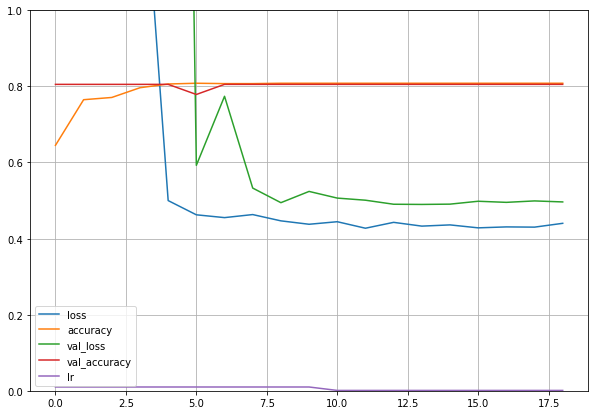

4/4 [==============================] - 0s 54ms/step - loss: 0.5135 - accuracy: 0.7917


[0.5135181546211243, 0.7916666865348816]

In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.axial,processing.abnormal)
processing.test_extractor(model2,processing.axial,processing.abnormal)


# Axial-acl

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 32.7957 - accuracy: 0.7316
Epoch 00001: val_accuracy improved from -inf to 0.84956, saving model to /content/drive/My Drive/Models/Resnet/Extractor/axial_acl.h5
51/51 [==============================] - 39s 768ms/step - loss: 32.7957 - accuracy: 0.7316 - val_loss: 129201905664.0000 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 1.4730 - accuracy: 0.7758
Epoch 00002: val_accuracy did not improve from 0.84956
51/51 [==============================] - 15s 296ms/step - loss: 1.4730 - accuracy: 0.7758 - val_loss: 8123.8633 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.8014
Epoch 00003: val_accuracy did not improve from 0.84956
51/51 [==============================] - 14s 282ms/step - loss: 0.6330 - accuracy: 0.8014 - val_loss: 39.7130 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 4/50
51/51 [====

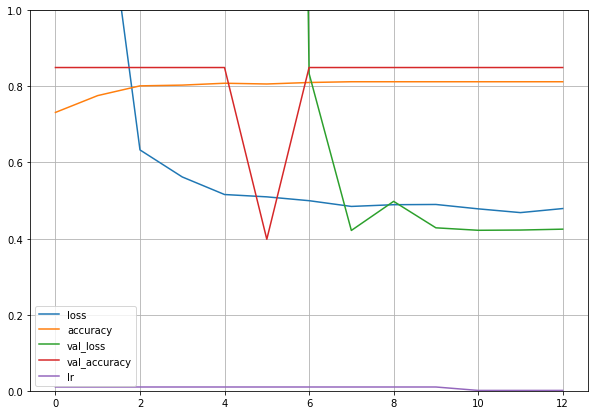

4/4 [==============================] - 0s 40ms/step - loss: 0.8528 - accuracy: 0.5500


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.axial,processing.acl)
processing.test_extractor(model2,processing.axial,processing.acl)
model1 = None
model2= None

# Axial-meniscal

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 22.9545 - accuracy: 0.5428
Epoch 00001: val_accuracy improved from -inf to 0.66372, saving model to /content/drive/My Drive/Models/Resnet/Extractor/axial_meniscus.h5
51/51 [==============================] - 27s 534ms/step - loss: 22.9545 - accuracy: 0.5428 - val_loss: 25165211648.0000 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 2.3334 - accuracy: 0.5595
Epoch 00002: val_accuracy did not improve from 0.66372
51/51 [==============================] - 15s 295ms/step - loss: 2.3334 - accuracy: 0.5595 - val_loss: 15928.3008 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.9187 - accuracy: 0.6450
Epoch 00003: val_accuracy did not improve from 0.66372
51/51 [==============================] - 14s 278ms/step - loss: 0.9187 - accuracy: 0.6450 - val_loss: 18.5901 - val_accuracy: 0.3186 - lr: 0.0100
Epoch 4/50
51/51 

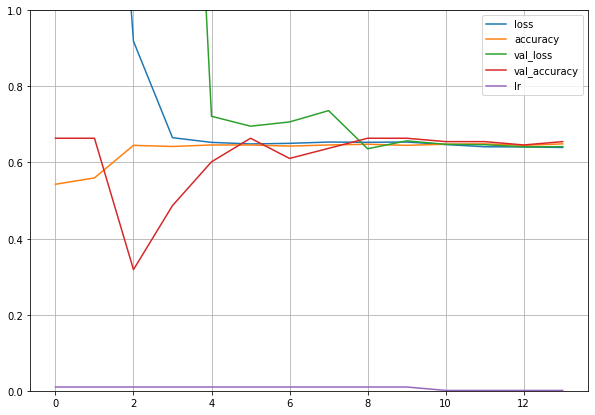

4/4 [==============================] - 0s 39ms/step - loss: 0.6936 - accuracy: 0.5500


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.axial,processing.meniscal)
processing.test_extractor(model2,processing.axial,processing.meniscal)
model1 = None
model2= None

# Coronal

# coronal-abnormal

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 27.2673 - accuracy: 0.6706
Epoch 00001: val_accuracy improved from -inf to 0.80531, saving model to /content/drive/My Drive/Models/Resnet/Extractor/coronal_abnormal.h5
51/51 [==============================] - 301s 6s/step - loss: 27.2673 - accuracy: 0.6706 - val_loss: 21150870.0000 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.7683 - accuracy: 0.7620
Epoch 00002: val_accuracy did not improve from 0.80531
51/51 [==============================] - 286s 6s/step - loss: 0.7683 - accuracy: 0.7620 - val_loss: 200.8042 - val_accuracy: 0.7965 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.7758
Epoch 00003: val_accuracy did not improve from 0.80531
51/51 [==============================] - 286s 6s/step - loss: 0.6201 - accuracy: 0.7758 - val_

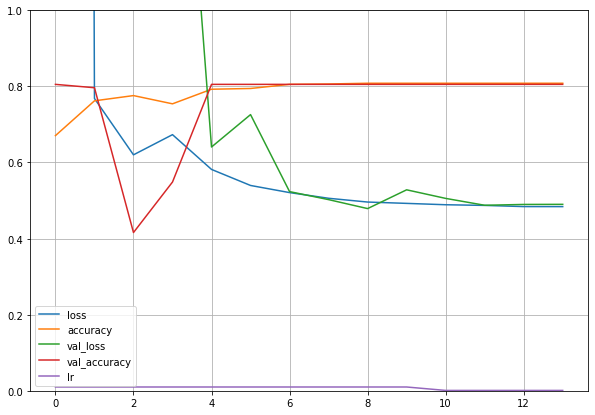

4/4 [==============================] - 5s 1s/step - loss: 0.5191 - accuracy: 0.7917


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.coronal,processing.abnormal)
processing.test_extractor(model2,processing.coronal,processing.abnormal)
model1 = None
model2= None

# coronal-acl

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 15.5337 - accuracy: 0.7414
Epoch 00001: val_accuracy improved from -inf to 0.84956, saving model to /content/drive/My Drive/Models/Resnet/Extractor/coronal_acl.h5
51/51 [==============================] - 25s 484ms/step - loss: 15.5337 - accuracy: 0.7414 - val_loss: 356085376.0000 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.8033
Epoch 00002: val_accuracy did not improve from 0.84956
51/51 [==============================] - 15s 291ms/step - loss: 0.6989 - accuracy: 0.8033 - val_loss: 1328.8271 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.8053
Epoch 00003: val_accuracy did not improve from 0.84956
51/51 [==============================] - 14s 278ms/step - loss: 0.5176 - accuracy: 0.8053 - v

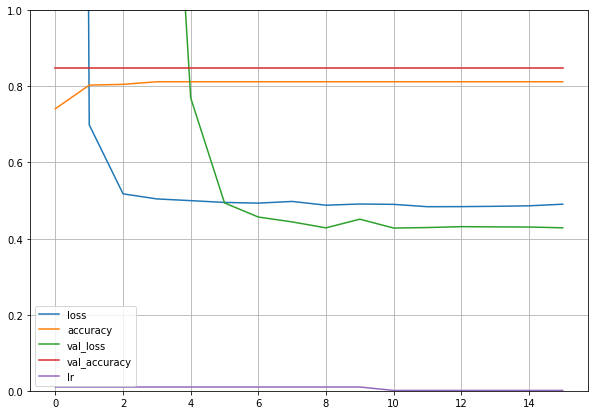

4/4 [==============================] - 1s 135ms/step - loss: 0.8697 - accuracy: 0.5500


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.coronal,processing.acl)
processing.test_extractor(model2,processing.coronal,processing.acl)
model1 = None
model2= None

# coronal-meniscal

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 30.4027 - accuracy: 0.5860
Epoch 00001: val_accuracy improved from -inf to 0.46018, saving model to /content/drive/My Drive/Models/Resnet/Extractor/coronal_meniscus.h5
51/51 [==============================] - 23s 449ms/step - loss: 30.4027 - accuracy: 0.5860 - val_loss: 1095564544.0000 - val_accuracy: 0.4602 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 1.1413 - accuracy: 0.6077
Epoch 00002: val_accuracy improved from 0.46018 to 0.66372, saving model to /content/drive/My Drive/Models/Resnet/Extractor/coronal_meniscus.h5
51/51 [==============================] - 19s 368ms/step - loss: 1.1413 - accuracy: 0.6077 - val_loss: 19334.8359 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.6450
Epoch 00003: val_accuracy did not improve from 0.66372
51/51 [==============================] - 15s 295ms/step - loss: 0.6810 - 

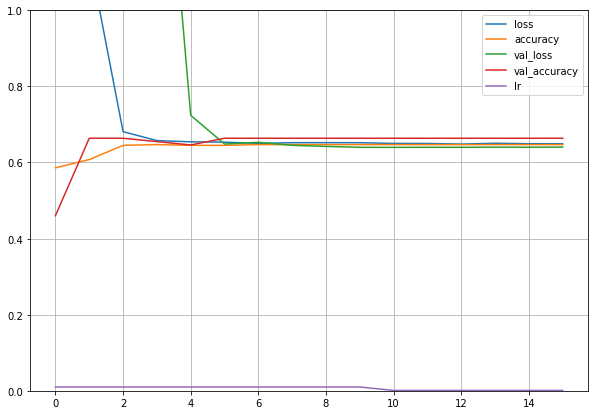

4/4 [==============================] - 0s 39ms/step - loss: 0.6965 - accuracy: 0.5667


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.coronal,processing.meniscal)
processing.test_extractor(model2,processing.coronal,processing.meniscal)
model1 = None
model2= None

# sagittal

# sagittal-abnormal

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 22.9923 - accuracy: 0.7148
Epoch 00001: val_accuracy improved from -inf to 0.80531, saving model to /content/drive/My Drive/Models/Resnet/Extractor/sagittal_abnormal.h5
51/51 [==============================] - 20s 401ms/step - loss: 22.9923 - accuracy: 0.7148 - val_loss: 731444477952.0000 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 2.1675 - accuracy: 0.7827
Epoch 00002: val_accuracy did not improve from 0.80531
51/51 [==============================] - 14s 282ms/step - loss: 2.1675 - accuracy: 0.7827 - val_loss: 79911944.0000 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.7945 - accuracy: 0.8014
Epoch 00003: val_accuracy did not improve from 0.80531
51/51 [==============================] - 14s 266ms/step - loss: 0.7945 - accuracy: 0.8014 - val_loss: 38664.5586 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 4

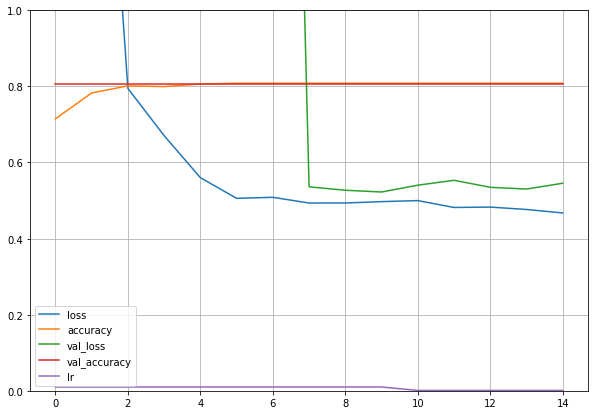

4/4 [==============================] - 0s 22ms/step - loss: 0.5128 - accuracy: 0.7917


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.sagittal,processing.abnormal)
processing.test_extractor(model2,processing.sagittal,processing.abnormal)
model1 = None
model2= None

# sagittal-acl

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 30.0894 - accuracy: 0.7158
Epoch 00001: val_accuracy improved from -inf to 0.15929, saving model to /content/drive/My Drive/Models/Resnet/Extractor/sagittal_acl.h5
51/51 [==============================] - 301s 6s/step - loss: 30.0894 - accuracy: 0.7158 - val_loss: 83184192.0000 - val_accuracy: 0.1593 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.7945
Epoch 00002: val_accuracy did not improve from 0.15929
51/51 [==============================] - 287s 6s/step - loss: 0.6674 - accuracy: 0.7945 - val_loss: 412.1945 - val_accuracy: 0.1504 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8053
Epoch 00003: val_accuracy improved from 0.15929 to 0.84071, saving model to /content/drive/My Drive/Models/Resnet/Extractor/sagittal_acl.h5
51/51 [==============================] - 293s 6s/step - loss: 0.5208 - accuracy: 0.8053 -

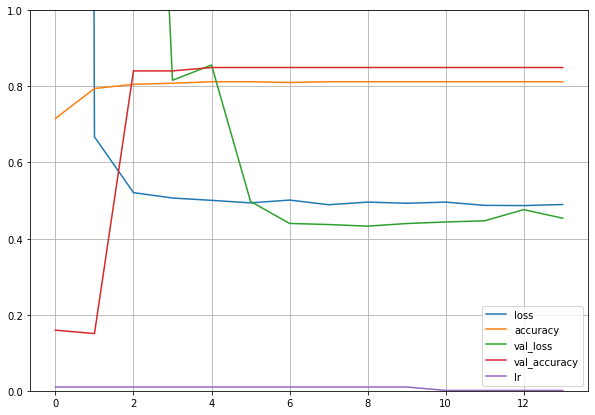

4/4 [==============================] - 5s 1s/step - loss: 0.8914 - accuracy: 0.5500


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.sagittal,processing.acl)
processing.test_extractor(model2,processing.sagittal,processing.acl)
model1 = None
model2= None

# sagittal-meniscal

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 22.3993 - accuracy: 0.6037
Epoch 00001: val_accuracy improved from -inf to 0.33628, saving model to /content/drive/My Drive/Models/Resnet/Extractor/sagittal_meniscus.h5
51/51 [==============================] - 19s 379ms/step - loss: 22.3993 - accuracy: 0.6037 - val_loss: 891078246400.0000 - val_accuracy: 0.3363 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.8544 - accuracy: 0.6372
Epoch 00002: val_accuracy did not improve from 0.33628
51/51 [==============================] - 14s 276ms/step - loss: 0.8544 - accuracy: 0.6372 - val_loss: 145970.5469 - val_accuracy: 0.3363 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.6323
Epoch 00003: val_accuracy improved from 0.33628 to 0.66372, saving model to /content/drive/My Drive/Models/Resnet/Extractor/sagittal_meni

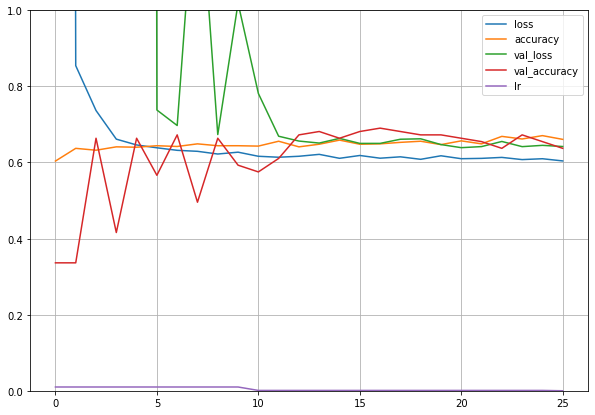

4/4 [==============================] - 0s 53ms/step - loss: 0.7553 - accuracy: 0.5083


In [0]:
model1,model2 = ResNet50(input_shape = (256, 256, 3))
processing.train_extractor(model2,processing.resnet,processing.sagittal,processing.meniscal)
processing.test_extractor(model2,processing.sagittal,processing.meniscal)
model1 = None
model2= None

# Train and test classifier

# function to load

In [0]:
def load_extractor(series,anomaly):
  model1,model2 = ResNet50(input_shape = (256, 256, 3))
  model_path = processing.path_model + processing.delim + processing.resnet + processing.delim + processing.extractor + processing.delim + series  + '_' + anomaly + processing.extension_model
  model1.load_weights(model_path,by_name=True)
  #model1.get_weights()
  return model1


# Axial

# axial-abnormal

Epoch 1/50
44/51 [========================>.....] - ETA: 0s - loss: 11135150080.0000 - accuracy: 0.7773
Epoch 00001: val_accuracy improved from -inf to 0.80531, saving model to /content/drive/My Drive/Models/Resnet/Classifier/axial_abnormal.h5
51/51 [==============================] - 3s 59ms/step - loss: 9635134464.0000 - accuracy: 0.7797 - val_loss: 0.6007 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 2/50
46/51 [==========================>...] - ETA: 0s - loss: 146.8846 - accuracy: 0.8065
Epoch 00002: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 132.9261 - accuracy: 0.8073 - val_loss: 0.5397 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 3/50
44/51 [========================>.....] - ETA: 0s - loss: 0.5241 - accuracy: 0.8068
Epoch 00003: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 0.5211 - accuracy: 0.8083 - val_loss: 0.5120 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 4/50
43/51 [

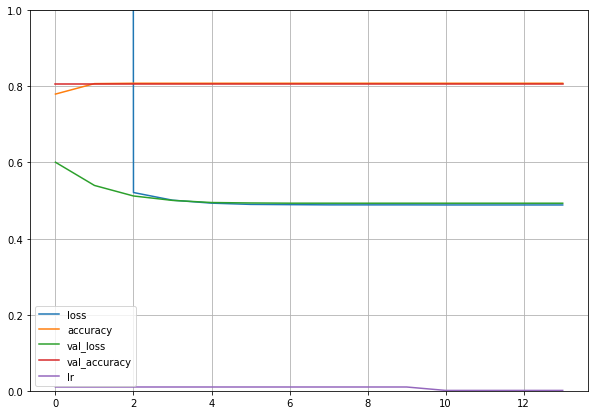

4/4 [==============================] - 0s 2ms/step - loss: 0.5122 - accuracy: 0.7917


[0.5121968984603882, 0.7916666865348816]

In [0]:
model = top_model()
model1 = load_extractor(processing.axial,processing.abnormal)
processing.train_classifier(model1,model,processing.resnet,processing.axial,processing.abnormal)
processing.test_classifier(model1,model,processing.axial,processing.abnormal)

# axial-acl

Epoch 1/50
44/51 [========================>.....] - ETA: 0s - loss: 757300658176.0000 - accuracy: 0.7307 
Epoch 00001: val_accuracy improved from -inf to 0.84956, saving model to /content/drive/My Drive/Models/Resnet/Classifier/axial_acl.h5
51/51 [==============================] - 0s 8ms/step - loss: 655284764672.0000 - accuracy: 0.7434 - val_loss: 0.6453 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 2/50
44/51 [========================>.....] - ETA: 0s - loss: 0.6105 - accuracy: 0.8136
Epoch 00002: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 3ms/step - loss: 0.6057 - accuracy: 0.8122 - val_loss: 0.5463 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 3/50
47/51 [==========================>...] - ETA: 0s - loss: 0.5451 - accuracy: 0.8096
Epoch 00003: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 3ms/step - loss: 0.5416 - accuracy: 0.8122 - val_loss: 0.4922 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 4/50
45/51 [======

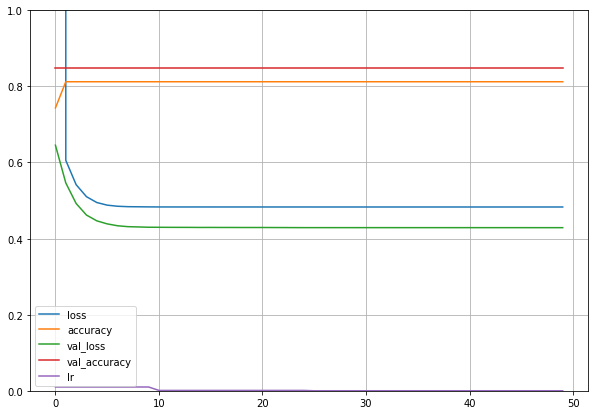

4/4 [==============================] - 0s 2ms/step - loss: 0.8643 - accuracy: 0.5500


[0.8642737865447998, 0.550000011920929]

In [0]:
model = top_model()
model1 = load_extractor(processing.axial,processing.acl)
processing.train_classifier(model1,model,processing.resnet,processing.axial,processing.acl)
processing.test_classifier(model1,model,processing.axial,processing.acl)

# axial-meniscal

Epoch 1/50
43/51 [========================>.....] - ETA: 0s - loss: 21462405120.0000 - accuracy: 0.5802
Epoch 00001: val_accuracy improved from -inf to 0.66372, saving model to /content/drive/My Drive/Models/Resnet/Classifier/axial_meniscus.h5
51/51 [==============================] - 0s 7ms/step - loss: 18149132288.0000 - accuracy: 0.5978 - val_loss: 0.6683 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 2/50
45/51 [=========================>....] - ETA: 0s - loss: 4539.9375 - accuracy: 0.6544
Epoch 00002: val_accuracy did not improve from 0.66372
51/51 [==============================] - 0s 3ms/step - loss: 4017.7217 - accuracy: 0.6470 - val_loss: 0.6516 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 3/50
46/51 [==========================>...] - ETA: 0s - loss: 0.6552 - accuracy: 0.6467
Epoch 00003: val_accuracy did not improve from 0.66372
51/51 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6470 - val_loss: 0.6445 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 4/50
44/51

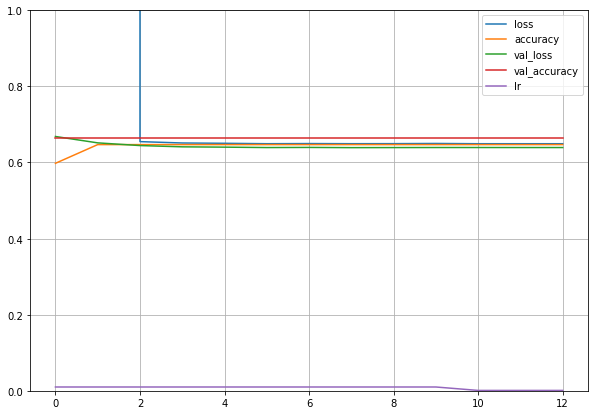

4/4 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.5667


[0.6937071681022644, 0.5666666626930237]

In [0]:
model = top_model()
model1 = load_extractor(processing.axial,processing.meniscal)
processing.train_classifier(model1,model,processing.resnet,processing.axial,processing.meniscal)
processing.test_classifier(model1,model,processing.axial,processing.meniscal)

# coronal

# coronal-abnormal

Epoch 1/50
45/51 [=========================>....] - ETA: 0s - loss: 11029034.0000 - accuracy: 0.6922
Epoch 00001: val_accuracy improved from -inf to 0.80531, saving model to /content/drive/My Drive/Models/Resnet/Classifier/coronal_abnormal.h5
51/51 [==============================] - 0s 8ms/step - loss: 9785438.0000 - accuracy: 0.6755 - val_loss: 379563.2500 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 2/50
46/51 [==========================>...] - ETA: 0s - loss: 110398.5938 - accuracy: 0.7120
Epoch 00002: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 101914.9375 - accuracy: 0.6971 - val_loss: 31378.1641 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 3/50
40/51 [======================>.......] - ETA: 0s - loss: 14634.2686 - accuracy: 0.7275
Epoch 00003: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 11512.5957 - accuracy: 0.7178 - val_loss: 1.6145 - val_accuracy: 0.8053 - lr: 0.0100


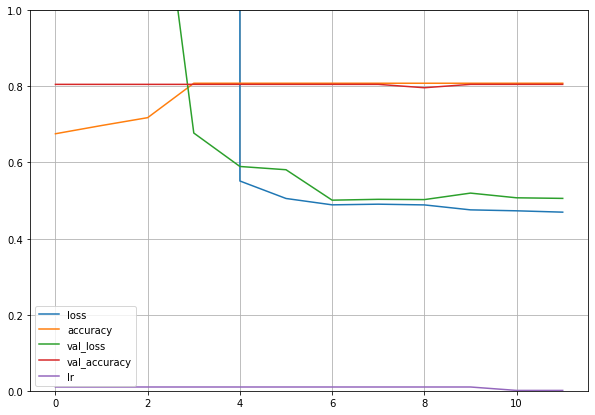

4/4 [==============================] - 0s 2ms/step - loss: 0.5333 - accuracy: 0.7917


[0.5333216190338135, 0.7916666865348816]

In [0]:
model = top_model()
model1 = load_extractor(processing.coronal,processing.abnormal)
processing.train_classifier(model1,model,processing.resnet,processing.coronal,processing.abnormal)
processing.test_classifier(model1,model,processing.coronal,processing.abnormal)

# coronal-acl

Epoch 1/50
44/51 [========================>.....] - ETA: 0s - loss: 1479579264.0000 - accuracy: 0.6795
Epoch 00001: val_accuracy improved from -inf to 0.84956, saving model to /content/drive/My Drive/Models/Resnet/Classifier/coronal_acl.h5
51/51 [==============================] - 0s 6ms/step - loss: 1280265344.0000 - accuracy: 0.6903 - val_loss: 0.6702 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 2/50
43/51 [========================>.....] - ETA: 0s - loss: 0.6357 - accuracy: 0.8081
Epoch 00002: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.8122 - val_loss: 0.5706 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 3/50
46/51 [==========================>...] - ETA: 0s - loss: 0.5612 - accuracy: 0.8087
Epoch 00003: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 3ms/step - loss: 0.5565 - accuracy: 0.8122 - val_loss: 0.5066 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 4/50
46/51 [=========

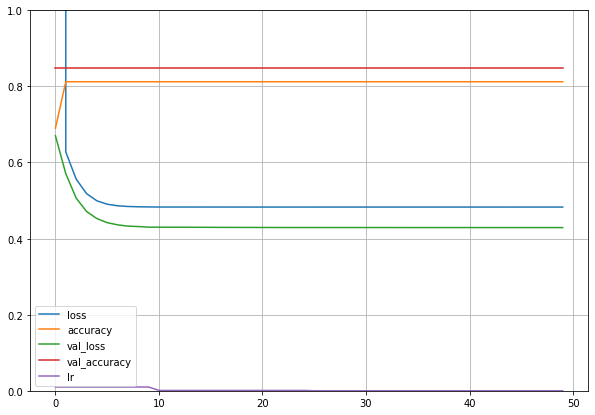

4/4 [==============================] - 0s 3ms/step - loss: 0.8628 - accuracy: 0.5500


[0.8627854585647583, 0.550000011920929]

In [0]:
model = top_model()
model1 = load_extractor(processing.coronal,processing.acl)
processing.train_classifier(model1,model,processing.resnet,processing.coronal,processing.acl)
processing.test_classifier(model1,model,processing.coronal,processing.acl)

# corornal-meniscal

Epoch 1/50
45/51 [=========================>....] - ETA: 0s - loss: 158298.0312 - accuracy: 0.5722
Epoch 00001: val_accuracy improved from -inf to 0.66372, saving model to /content/drive/My Drive/Models/Resnet/Classifier/coronal_meniscus.h5
51/51 [==============================] - 0s 6ms/step - loss: 140086.8438 - accuracy: 0.5929 - val_loss: 0.6764 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 2/50
45/51 [=========================>....] - ETA: 0s - loss: 453.8354 - accuracy: 0.6300
Epoch 00002: val_accuracy did not improve from 0.66372
51/51 [==============================] - 0s 3ms/step - loss: 401.6995 - accuracy: 0.6342 - val_loss: 0.6536 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 3/50
47/51 [==========================>...] - ETA: 0s - loss: 0.6588 - accuracy: 0.6394
Epoch 00003: val_accuracy did not improve from 0.66372
51/51 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6470 - val_loss: 0.6459 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 4/50
44/51 [========

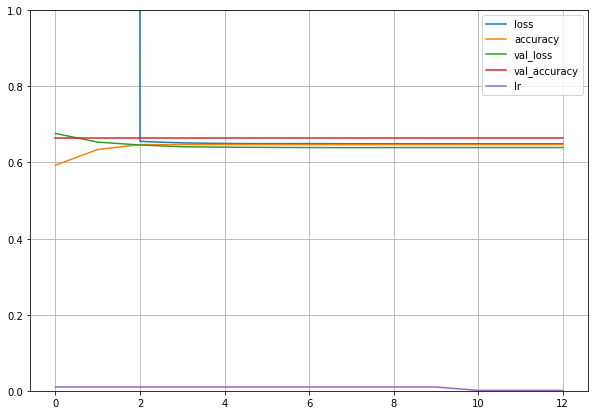

4/4 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5667


[0.6943582892417908, 0.5666666626930237]

In [0]:
model = top_model()
model1 = load_extractor(processing.coronal,processing.meniscal)
processing.train_classifier(model1,model,processing.resnet,processing.coronal,processing.meniscal)
processing.test_classifier(model1,model,processing.coronal,processing.meniscal)

# sagittal

# sagittal-abnormal

Epoch 1/50
42/51 [=======================>......] - ETA: 0s - loss: 295638466560.0000 - accuracy: 0.7762
Epoch 00001: val_accuracy improved from -inf to 0.80531, saving model to /content/drive/My Drive/Models/Resnet/Classifier/sagittal_abnormal.h5
51/51 [==============================] - 3s 61ms/step - loss: 244185153536.0000 - accuracy: 0.7847 - val_loss: 0.5968 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 2/50
43/51 [========================>.....] - ETA: 0s - loss: 0.5647 - accuracy: 0.8128
Epoch 00002: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 0.5634 - accuracy: 0.8083 - val_loss: 0.5370 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 3/50
46/51 [==========================>...] - ETA: 0s - loss: 0.5195 - accuracy: 0.8109
Epoch 00003: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 0.5208 - accuracy: 0.8083 - val_loss: 0.5113 - val_accuracy: 0.8053 - lr: 0.0100
Epoch 4/50
44/51

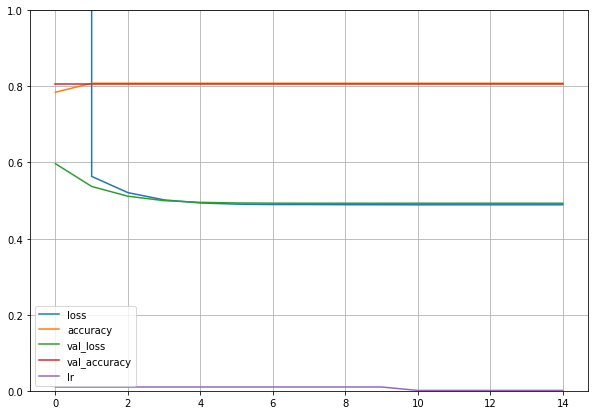

4/4 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.7917


[0.5123617649078369, 0.7916666865348816]

In [0]:
model = top_model()
model1 = load_extractor(processing.sagittal,processing.abnormal)
processing.train_classifier(model1,model,processing.resnet,processing.sagittal,processing.abnormal)
processing.test_classifier(model1,model,processing.sagittal,processing.abnormal)

# sagittal-acl

Epoch 1/50
44/51 [========================>.....] - ETA: 0s - loss: 10.2655 - accuracy: 0.6830
Epoch 00001: val_accuracy improved from -inf to 0.84956, saving model to /content/drive/My Drive/Models/Resnet/Classifier/sagittal_acl.h5
51/51 [==============================] - 0s 6ms/step - loss: 8.9608 - accuracy: 0.7060 - val_loss: 0.5065 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 2/50
44/51 [========================>.....] - ETA: 0s - loss: 0.7700 - accuracy: 0.7614
Epoch 00002: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 3ms/step - loss: 0.7611 - accuracy: 0.7532 - val_loss: 0.6641 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 3/50
46/51 [==========================>...] - ETA: 0s - loss: 0.5544 - accuracy: 0.8011
Epoch 00003: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 3ms/step - loss: 0.5442 - accuracy: 0.8043 - val_loss: 0.4385 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 4/50
48/51 [=========================

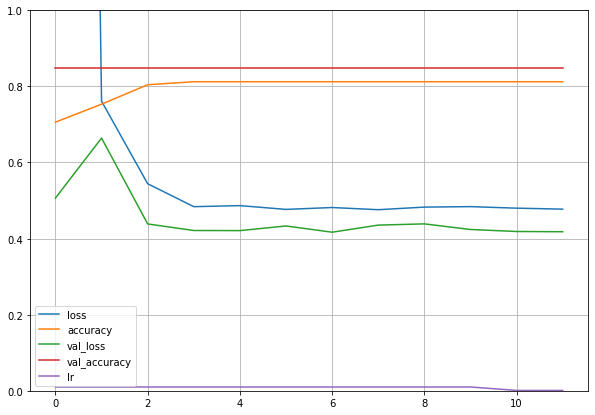

4/4 [==============================] - 0s 3ms/step - loss: 0.8545 - accuracy: 0.5500


[0.8544818758964539, 0.550000011920929]

In [0]:
model = top_model()
model1 = load_extractor(processing.sagittal,processing.acl)
processing.train_classifier(model1,model,processing.resnet,processing.sagittal,processing.acl)
processing.test_classifier(model1,model,processing.sagittal,processing.acl)

# sagittal-meniscal

Epoch 1/50
43/51 [========================>.....] - ETA: 0s - loss: 7.4977 - accuracy: 0.5884 
Epoch 00001: val_accuracy improved from -inf to 0.55752, saving model to /content/drive/My Drive/Models/Resnet/Classifier/sagittal_meniscus.h5
51/51 [==============================] - 0s 7ms/step - loss: 6.7184 - accuracy: 0.5880 - val_loss: 7.2292 - val_accuracy: 0.5575 - lr: 0.0100
Epoch 2/50
37/51 [====================>.........] - ETA: 0s - loss: 1.8747 - accuracy: 0.5865
Epoch 00002: val_accuracy improved from 0.55752 to 0.62832, saving model to /content/drive/My Drive/Models/Resnet/Classifier/sagittal_meniscus.h5
51/51 [==============================] - 0s 5ms/step - loss: 1.9409 - accuracy: 0.6008 - val_loss: 1.7126 - val_accuracy: 0.6283 - lr: 0.0100
Epoch 3/50
45/51 [=========================>....] - ETA: 0s - loss: 1.0332 - accuracy: 0.6200
Epoch 00003: val_accuracy improved from 0.62832 to 0.66372, saving model to /content/drive/My Drive/Models/Resnet/Classifier/sagittal_meniscus.h

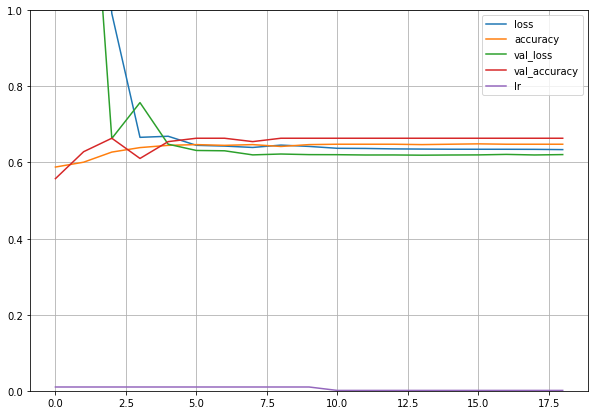

4/4 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5667


[0.699770987033844, 0.5666666626930237]

In [0]:
model = top_model()
model1 = load_extractor(processing.sagittal,processing.meniscal)
processing.train_classifier(model1,model,processing.resnet,processing.sagittal,processing.meniscal)
processing.test_classifier(model1,model,processing.sagittal,processing.meniscal)

# Regressor

In [0]:
def regressor():  
  log_reg = keras.models.Sequential()
  #creates a classifier using logistic regression takes 3 inputs (the 3 probs of the same 
  # anomaly from the 3 serieses and outpust one probabilty as final output of this anomaly)
  log_reg.add(keras.layers.Dense(units=1 , activation = 'sigmoid' , input_dim = 3))
  log_reg.compile(loss='binary_crossentropy',optimizer = keras.optimizers.Adam(0.01),metrics=['accuracy'])
  return log_reg

# Train and test Regressor

# Abnormal

Epoch 1/50
41/51 [=======================>......] - ETA: 0s - loss: 0.6049 - accuracy: 0.7110
Epoch 00001: val_accuracy improved from -inf to 0.80531, saving model to /content/drive/My Drive/Models/Resnet/Regressor/abnormal.h5
51/51 [==============================] - 1s 24ms/step - loss: 0.5879 - accuracy: 0.7276 - val_loss: 0.5037 - val_accuracy: 0.8053
Epoch 2/50
47/51 [==========================>...] - ETA: 0s - loss: 0.4957 - accuracy: 0.8064
Epoch 00002: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 0.4928 - accuracy: 0.8083 - val_loss: 0.4931 - val_accuracy: 0.8053
Epoch 3/50
50/51 [============================>.] - ETA: 0s - loss: 0.4869 - accuracy: 0.8100
Epoch 00003: val_accuracy did not improve from 0.80531
51/51 [==============================] - 0s 3ms/step - loss: 0.4893 - accuracy: 0.8083 - val_loss: 0.4930 - val_accuracy: 0.8053
Epoch 4/50
46/51 [==========================>...] - ETA: 0s - loss: 0.4888 - accuracy: 

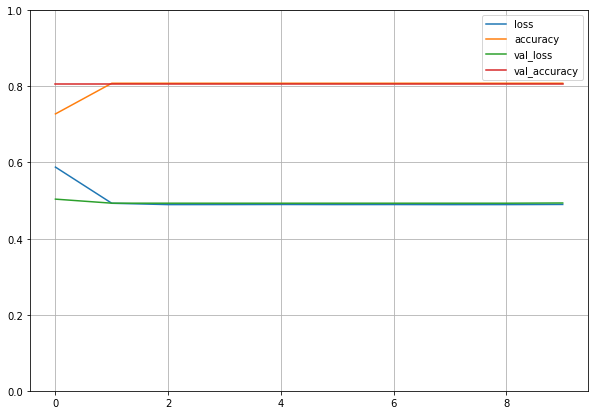

4/4 [==============================] - 0s 3ms/step - loss: 0.5182 - accuracy: 0.7917


[0.5181904435157776, 0.7916666865348816]

In [0]:
loaded_model_axial_abnormal  = load_extractor(processing.axial,processing.abnormal)

loaded_model_saggital_abnormal = load_extractor(processing.sagittal,processing.abnormal)

loaded_model_coronal_abnormal = load_extractor(processing.coronal,processing.abnormal)

logistic_rogressor = regressor()
processing.train_regressor(logistic_rogressor,loaded_model_axial_abnormal,loaded_model_saggital_abnormal,loaded_model_coronal_abnormal,processing.resnet,processing.abnormal)

processing.test_regressor(loaded_model_axial_abnormal,loaded_model_saggital_abnormal,loaded_model_coronal_abnormal,processing.resnet,processing.abnormal)

# acl

Epoch 1/50
34/51 [===================>..........] - ETA: 0s - loss: 0.7277 - accuracy: 0.4235
Epoch 00001: val_accuracy improved from -inf to 0.84956, saving model to /content/drive/My Drive/Models/Resnet/Regressor/acl.h5
51/51 [==============================] - 0s 7ms/step - loss: 0.6839 - accuracy: 0.5477 - val_loss: 0.5298 - val_accuracy: 0.8496
Epoch 2/50
50/51 [============================>.] - ETA: 0s - loss: 0.5156 - accuracy: 0.8140
Epoch 00002: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.8122 - val_loss: 0.4465 - val_accuracy: 0.8496
Epoch 3/50
49/51 [===========================>..] - ETA: 0s - loss: 0.4888 - accuracy: 0.8112
Epoch 00003: val_accuracy did not improve from 0.84956
51/51 [==============================] - 0s 2ms/step - loss: 0.4875 - accuracy: 0.8122 - val_loss: 0.4274 - val_accuracy: 0.8496
Epoch 4/50
49/51 [===========================>..] - ETA: 0s - loss: 0.4884 - accuracy: 0.8092

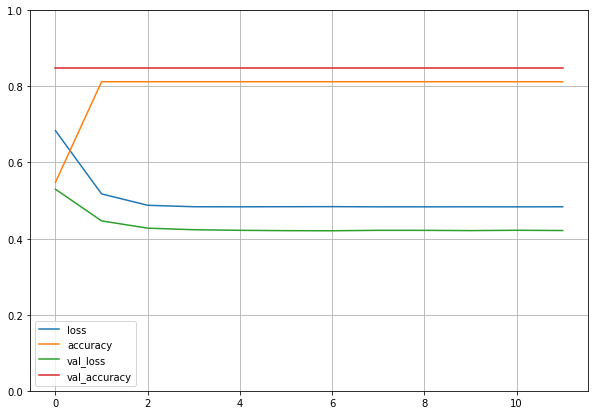

4/4 [==============================] - 0s 2ms/step - loss: 0.7051 - accuracy: 0.5500


[0.7050759196281433, 0.550000011920929]

In [0]:
loaded_model_axial_acl  = load_extractor(processing.axial,processing.acl)

loaded_model_saggital_acl = load_extractor(processing.sagittal,processing.acl)

loaded_model_coronal_acl = load_extractor(processing.coronal,processing.acl)

logistic_rogressor = regressor()
processing.train_regressor(logistic_rogressor,loaded_model_axial_acl,loaded_model_saggital_acl,loaded_model_coronal_acl,processing.resnet,processing.acl)

processing.test_regressor(loaded_model_axial_acl,loaded_model_saggital_acl,loaded_model_coronal_acl,processing.resnet,processing.acl)

# meniscal

Epoch 1/50
44/51 [========================>.....] - ETA: 0s - loss: 0.6591 - accuracy: 0.6330
Epoch 00001: val_accuracy improved from -inf to 0.66372, saving model to /content/drive/My Drive/Models/Resnet/Regressor/meniscus.h5
51/51 [==============================] - 0s 5ms/step - loss: 0.6581 - accuracy: 0.6332 - val_loss: 0.6397 - val_accuracy: 0.6637
Epoch 2/50
49/51 [===========================>..] - ETA: 0s - loss: 0.6493 - accuracy: 0.6469
Epoch 00002: val_accuracy did not improve from 0.66372
51/51 [==============================] - 0s 2ms/step - loss: 0.6491 - accuracy: 0.6470 - val_loss: 0.6398 - val_accuracy: 0.6637
Epoch 3/50
48/51 [===========================>..] - ETA: 0s - loss: 0.6451 - accuracy: 0.6531
Epoch 00003: val_accuracy did not improve from 0.66372
51/51 [==============================] - 0s 2ms/step - loss: 0.6491 - accuracy: 0.6470 - val_loss: 0.6394 - val_accuracy: 0.6637
Epoch 4/50
46/51 [==========================>...] - ETA: 0s - loss: 0.6503 - accuracy: 0

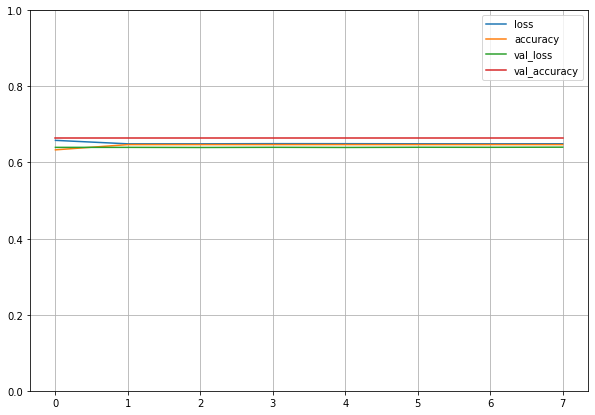

4/4 [==============================] - 0s 2ms/step - loss: 0.7024 - accuracy: 0.5667


[0.7024316191673279, 0.5666666626930237]

In [0]:
loaded_model_axial_meniscal  = load_extractor(processing.axial,processing.meniscal)

loaded_model_saggital_meniscal = load_extractor(processing.sagittal,processing.meniscal)

loaded_model_coronal_meniscal = load_extractor(processing.coronal,processing.meniscal)

logistic_rogressor = regressor()
processing.train_regressor(logistic_rogressor,loaded_model_axial_meniscal,loaded_model_saggital_meniscal,loaded_model_coronal_meniscal,processing.resnet,processing.meniscal)

processing.test_regressor(loaded_model_axial_meniscal,loaded_model_saggital_meniscal,loaded_model_coronal_meniscal,processing.resnet,processing.meniscal)

# Train the keras resnet

In [0]:
modleres = keras.models.Sequential()
modleres.add(tf.keras.applications.ResNet50(
    include_top=False,  input_tensor=None, input_shape=(256, 256, 3),
    pooling=None)) 
modleres.add(AveragePooling2D((2, 2)))
modleres.add(Flatten())
modleres.add(Dense(1000, activation='relu'))
modleres.add(Dense(1, activation='sigmoid'))
modleres.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#modleres = AveragePooling2D((2, 2))(modleres)
#modleres = Flatten()(modleres)
#modleres = Dense(1000, activation='relu')(modleres)
#modleres = Dense(1, activation='sigmoid')(modleres)
#model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [0]:
processing.train_extractor(modleres,processing.resnet,processing.axial,processing.meniscal)

In [0]:
processing.test_extractor(modleres,processing.axial,processing.meniscal)